# **Image Transformation**

This book will explore using `OpenCV` to transform a forward facing image taken from a vehicle into a bird-eye view.

## Imports

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

from src.utility import *

## **Motivation**

Imagine standing in the middle of a long stretch of road. The is a solid lane marker to your left and right that extends the entire length of the road. As you focus on the middle portion of the road, you'll see that the lane lines look almost like they are converging though you know they run in parallel. We can see the same phenomenon with pictures taken from cameras. For example, let's take a look at a test image. Pay attention to how the lane lines seem to converge the further out they go.

<div>
<img src="test_images/straight_lines1.jpg" width="1000"/>
</div>

The point in the horizon that the lines seem to converge to is known as the vanishing point and the reason as to why they seem to converge has to do with dimunation. That is the further out we look, the smaller the objects look resulting in a convergin perspective. This is great and all, but what does it have to do with our computer vision application? Well we inherintly know that though they may look it, the lines do not converge. The computer, however, just sees an image of lines that seem to get closer to one another as we move up the image. Thought we may be able to detect the polylines of lane lines, if we want to include any measurments (distance, radius, etc.) the results will not be an accurate representation of the real-life measurements

To remedy this, we can transform our image into a birds-eye view such that we have a top-down flat representation of the lane ahead. This perspective will allow us to calculate various measurments with confidence of accurate represenation. Let's take a look at the image we will try to transform.

<div>
<img src="test_images/test2.jpg" width="1000"/>
</div>

We see that the vehicle is moving through a left turn curve, however the perspective phenomenon makes it seem like the left turn has yet to come. The birds-eye view might show otherwise.

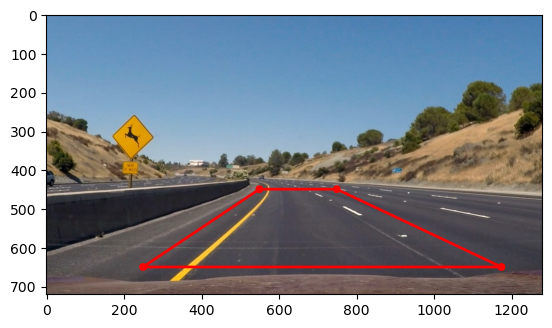

In [2]:
orig_img = cv2.imread('test_images/test2.jpg')
img = cv2.cvtColor(orig_img, cv2.COLOR_BGR2RGB)

roi_points = np.int32([[
    (550, 450),
    (250, 650),
    (1175, 650),
    (750, 450)
]])

img = draw_roi(img, roi_points, (255, 0, 0))

plt.imshow(img)

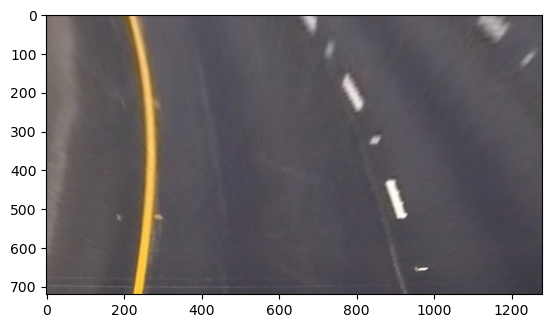

In [3]:
src_points = np.float32(roi_points.reshape(-1, 2))

dst_points = np.float32([
    (100, 0),
    (100, 750),
    (1100, 750),
    (1100, 0)
])

matrix = cv2.getPerspectiveTransform(src_points, dst_points)
result = cv2.warpPerspective(orig_img, matrix, (orig_img.shape[1], orig_img.shape[0]))
result = cv2.cvtColor(result, cv2.COLOR_BGR2RGB)

plt.imshow(result)

In [91]:
hls = cv2.cvtColor(result, cv2.COLOR_RGB2HLS)
hsv = cv2.cvtColor(result, cv2.COLOR_RGB2HSV)

# hls_channels = [hls[:,:,c] for c in range(3)]
# hsv_channels = [hsv[:,:,c] for c in range(3)]
imgs = []
for c, hls, hsv in enumerate(zip(hls, hsv)):
    imgs.append(hls[:,:,c])
    imgs.append(hsv[:,:,c])

# fig, axs = plt.subplots(nrows=3, ncols=3)
# axs = axs.flatten()
# for img, ax in zip(imgs, axs):
#     ax.imshow(img)
# plt.show()

# imgs

ValueError: not enough values to unpack (expected 3, got 2)